<a href="https://colab.research.google.com/github/Sugandh-Mishra/attacks/blob/main/jsma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models, datasets
import numpy as np

In [2]:
def train_model():
    (train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
    train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255.0
    test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255.0
    
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_images, train_labels, epochs=2, validation_data=(test_images, test_labels))
  
    return model, test_images, test_labels, train_images

In [3]:
# Train the model
model, x_test, y_test, x_train = train_model()


Epoch 1/2
1875/1875 [==============================] - 12s 4ms/step - loss: 0.1223 - accuracy: 0.9622 - val_loss: 0.0535 - val_accuracy: 0.9835
Epoch 2/2
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0415 - accuracy: 0.9868 - val_loss: 0.0286 - val_accuracy: 0.9898


In [5]:
def jsma_attack(model, x, y, epsilon=0.1, max_iters=100):
    perturbed_x = tf.identity(x)
    for _ in range(max_iters):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_x)
            predictions = model(perturbed_x)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)
        
        gradients = tape.gradient(loss, perturbed_x)
        gradients = tf.sign(gradients)
        perturbed_x = perturbed_x + epsilon * gradients
        perturbed_x = tf.clip_by_value(perturbed_x, clip_value_min=x-epsilon, clip_value_max=x+epsilon)
        adv_pred=model(perturbed_x)
        adv_lab=np.argmax(adv_pred.numpy(),axis=1)
        adv_prob=np.max(tf.nn.softmax(adv_pred).numpy(),axis=1)
    return perturbed_x,y,adv_lab,adv_prob

In [6]:
def test_perturbed_images(model, x, y, epsilon=0.1, max_iters=100):
    perturbed_images,labels, adversarial_labels, adversarial_probs = jsma_attack(model, x, y, epsilon, max_iters)
    predictions = model(perturbed_images)
    success_rate = np.mean(tf.argmax(predictions, axis=-1) == tf.argmax(y_test, axis=-1))

    # success_rate = np.mean(tf.argmax(predictions, axis=1) == tf.argmax(y, axis=1))
    return success_rate,perturbed_images

In [7]:
#  Perform JSMA attack and test perturbed images
epsilon = 0.1
max_iters = 1
success_rate,perturbed_images = test_perturbed_images(model, x_test, y_test, epsilon, max_iters)


In [8]:

print("Original Image - True Label: {}".format(tf.argmax(y_test, axis=-1)))
print("Perturbed Image - Predicted Label: {}".format(tf.argmax(model(perturbed_images), axis=-1)))
print("Success Rate of JSMA Attack: {:.2f}%".format(success_rate * 100))


Original Image - True Label: 7
Perturbed Image - Predicted Label: [7 2 1 ... 4 5 6]
Success Rate of JSMA Attack: 10.69%


In [11]:
adversarial_images, original_labels, attacked_labels, probs = jsma_attack(model, x_test, y_test)


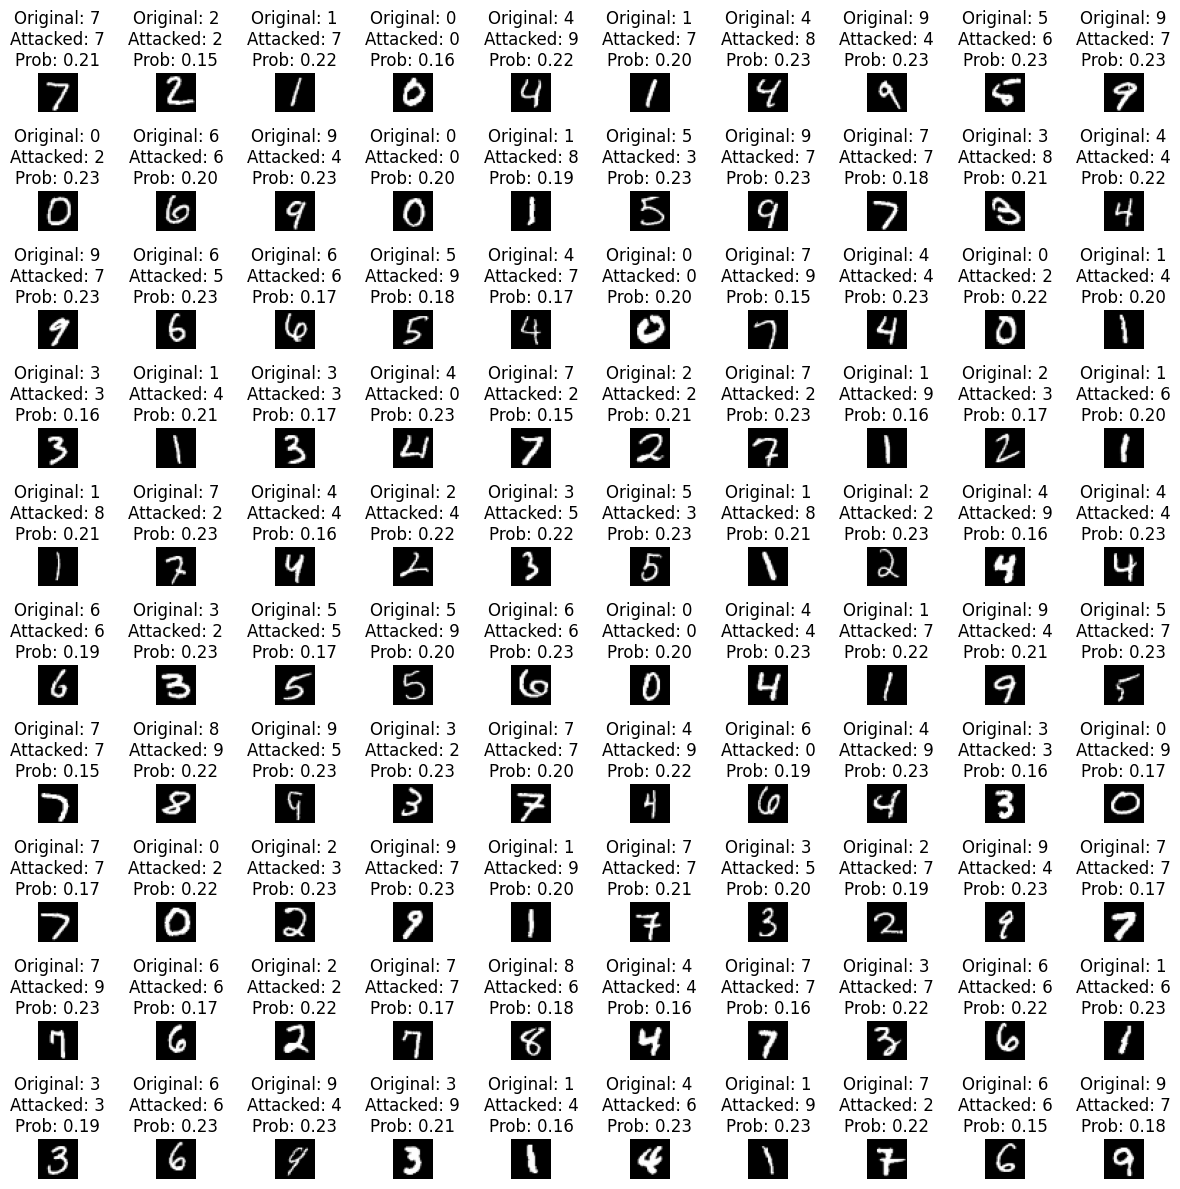

In [17]:

def visualize_jsma_attack(original_images, attacked_images, original_labels, attacked_labels, probs):
    num_images = len(original_images)
    num_rows = 10
    num_cols = 10
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i][j].imshow(original_images[index].reshape(28, 28), cmap='gray')
                axes[i][j].axis('off')
                axes[i][j].set_title(f'Original: {original_labels[index]}\nAttacked: {attacked_labels[index]}\nProb: {probs[index]:.2f}')
            else:
                axes[i][j].axis('off')
    plt.tight_layout()
    plt.show()
visualize_jsma_attack(x_test,adversarial_images,original_labels,attacked_labels,probs)